In [30]:
import torch
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons





In [31]:
X, y = make_moons(n_samples=1000, noise=0.03, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [34]:
X_train[:10], y_train[:10]

(tensor([[ 1.9758,  0.2076],
         [-0.9608,  0.4007],
         [-0.0986,  1.0231],
         [-0.1083,  0.9919],
         [ 0.3767, -0.2620],
         [-0.2237,  0.9529],
         [ 0.5371, -0.3586],
         [ 0.1013,  0.0867],
         [ 0.4661,  0.8945],
         [-0.9630,  0.2070]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

In [35]:
X_test[:10], y_test[:10]

(tensor([[ 0.5172, -0.3785],
         [ 0.7536,  0.6871],
         [ 1.2408, -0.4597],
         [ 0.6236,  0.8408],
         [ 1.8526, -0.0454],
         [ 1.9586,  0.1054],
         [ 0.9872,  0.2803],
         [ 1.0166,  0.0972],
         [ 1.1619, -0.5667],
         [ 0.7189,  0.6615]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

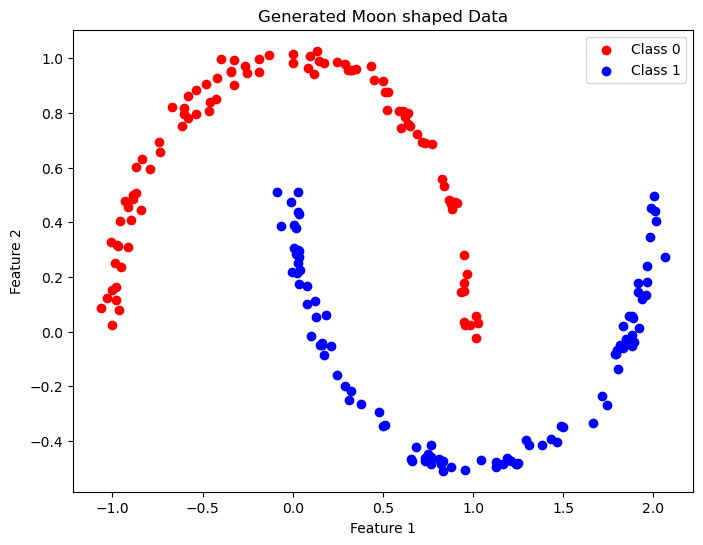

In [36]:
# Visualisation

plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][100:200, 0], X[y == 0][100:200, 1], color="red", label="Class 0")
plt.scatter(X[y == 1][100:200, 0], X[y == 1][100:200, 1], color="blue", label="Class 1")
plt.title("Generated Moon shaped Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [37]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "w") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [38]:
NUM_FEATURES = 2
NUM_CLASSES = 1

In [51]:
from torch import nn

class MoonModel(nn.Module):
    def __init__(self, input_features, out_features):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=out_features),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)


In [52]:
model_1 = MoonModel(NUM_FEATURES,NUM_CLASSES).to(device)
model_1

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): ReLU()
  )
)

In [53]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [54]:
from torchmetrics import Accuracy, ConfusionMatrix

accuracy = Accuracy(task='binary').to(device)
confmat = ConfusionMatrix(task='binary', num_classes=2).to(device)

In [62]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    
    # put model in training mode
    model_1.train()

    y_logits = model_1(X_train)
    y_pred = torch.sigmoid(y_logits).squeeze()

    # calculate training loss and training accuracy
    loss = loss_fn(y_logits.squeeze(),y_train)
    acc = accuracy(y_pred,y_train)
    
    # zero-out the gradients
    optimizer.zero_grad()

    # compute all gradients of all parameters
    loss.backward()

    # optimize all parameters
    optimizer.step()

    # put the model in evaluation mode
    model_1.eval()

    # enabling inference mode
    with torch.inference_mode():
        test_logits = model_1(X_test)
        test_pred = torch.sigmoid(test_logits).squeeze()
        
        test_loss = loss_fn(test_logits.squeeze(), y_test)
        test_acc = accuracy(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")
    


Epoch: 0 | Loss: 0.35179, Accuracy: 0.99 | Test Loss: 0.35077, Test Acc: 1.00
Epoch: 100 | Loss: 0.35059, Accuracy: 0.99 | Test Loss: 0.34984, Test Acc: 1.00
Epoch: 200 | Loss: 0.34974, Accuracy: 1.00 | Test Loss: 0.34927, Test Acc: 1.00
Epoch: 300 | Loss: 0.34913, Accuracy: 1.00 | Test Loss: 0.34873, Test Acc: 1.00
Epoch: 400 | Loss: 0.34870, Accuracy: 1.00 | Test Loss: 0.34837, Test Acc: 1.00
Epoch: 500 | Loss: 0.34842, Accuracy: 1.00 | Test Loss: 0.34808, Test Acc: 1.00
Epoch: 600 | Loss: 0.34819, Accuracy: 1.00 | Test Loss: 0.34789, Test Acc: 1.00
Epoch: 700 | Loss: 0.34797, Accuracy: 1.00 | Test Loss: 0.34771, Test Acc: 1.00
Epoch: 800 | Loss: 0.34777, Accuracy: 1.00 | Test Loss: 0.34759, Test Acc: 1.00
Epoch: 900 | Loss: 0.34764, Accuracy: 1.00 | Test Loss: 0.34746, Test Acc: 1.00


In [56]:
model_1.eval()
with torch.inference_mode():
    y_pred = torch.sigmoid(model_1(X_test))

y_pred[:10]

tensor([[0.9946],
        [0.5000],
        [0.9998],
        [0.5000],
        [0.9999],
        [0.9997],
        [0.5000],
        [0.5000],
        [0.9998],
        [0.5000]])

In [57]:
cm = confmat(y_pred.squeeze(),y_test)
cm

tensor([[100,   0],
        [  0, 100]])

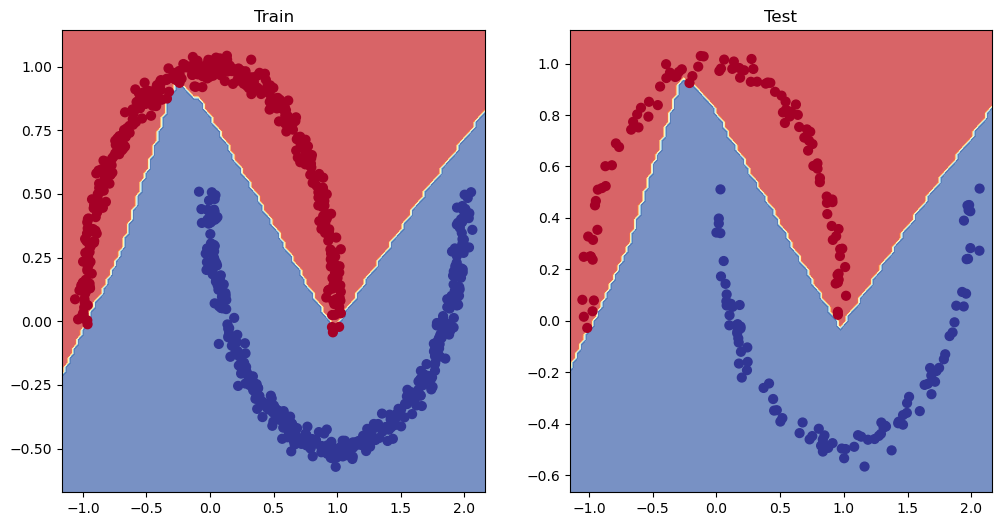

In [58]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train.cpu(), y_train.cpu())
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test.cpu(), y_test.cpu())

In [59]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = "moon_model_classification_excercise"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to : models/moon_model_classification_excercise


In [60]:
loaded_model = MoonModel(NUM_FEATURES,NUM_CLASSES)
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

print(f"Loaded model: \n{loaded_model}")
print(f"Model on device: \n{next(loaded_model.parameters()).device}")

Loaded model: 
MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
    (7): ReLU()
  )
)
Model on device: 
cpu


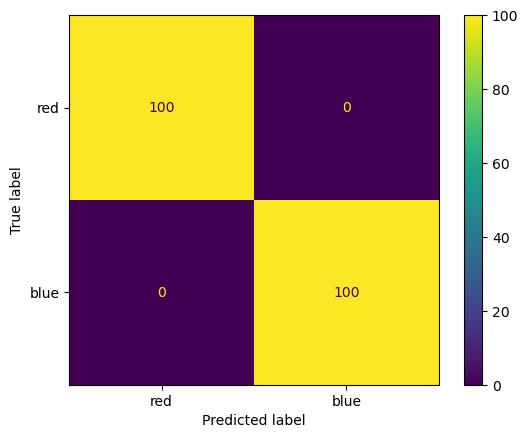

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm.numpy(), display_labels=["red", "blue"])
disp.plot()
plt.show()